In [169]:
import re
import pandas as pd
import numpy as np
from collections import defaultdict

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

# nltk
from nltk import tokenize

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Plotting tools
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('fivethirtyeight')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from tqdm import tqdm_notebook as tqdm
from tqdm import trange

import os

In [170]:
files = [i for i in os.listdir("../chapters") if i.endswith("txt")]

In [171]:
chapters = {}
for i in files:
    num, title = i.split(': ')
    title = title[:-4]
    file = open('../chapters/' + i, 'r')
    chapters[int(num)] = title, file.read()

In [172]:
analyzer = SentimentIntensityAnalyzer()

In [173]:
for i in tqdm(chapters, desc='Progress'):
    text = chapters[i][1].replace('\n', ' ')
    sentence_list = tokenize.sent_tokenize(text)
    sentiments = {'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}
        
    for sentence in sentence_list:
        vs = analyzer.polarity_scores(sentence)
        sentiments['compound'] += vs['compound']
        sentiments['neg'] += vs['neg']
        sentiments['neu'] += vs['neu']
        sentiments['pos'] += vs['pos']
            
    sentiments['compound'] = sentiments['compound'] / len(sentence_list)
    sentiments['neg'] = sentiments['neg'] / len(sentence_list)
    sentiments['neu'] = sentiments['neu'] / len(sentence_list)
    sentiments['pos'] = sentiments['pos'] / len(sentence_list)
    
    chapters[i] = (chapters[i][0], chapters[i][1], sentiments)


In [174]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

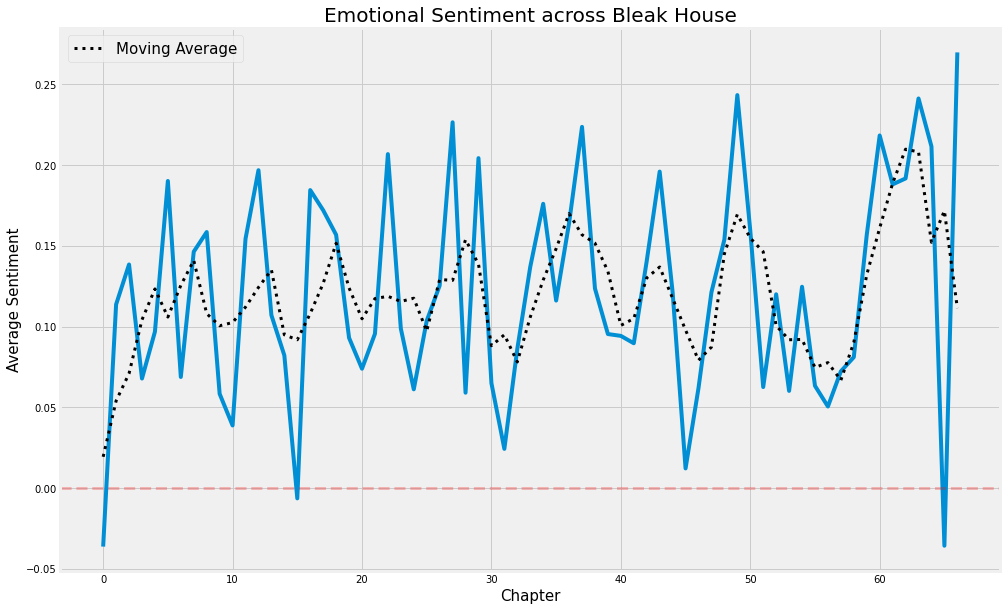

In [175]:
length = 67
x = np.linspace(0, length - 1, num=length)
y = []
for i in range(length):
    y.append(chapters[i+1][2]['compound'])

plt.figure(figsize=(15, 10))

plt.plot(y)
plt.plot(movingaverage(y, 4), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=15)
plt.title('Emotional Sentiment across Bleak House', fontsize=20)
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

In [176]:


import pandas as pd
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer


def text_emotion(df, column):
    '''
    Takes a DataFrame and a specified column of text and adds 10 columns to the
    DataFrame for each of the 10 emotions in the NRC Emotion Lexicon, with each
    column containing the value of the text in that emotions
    INPUT: DataFrame, string
    OUTPUT: the original DataFrame with ten new columns
    '''

    new_df = df.copy()

    filepath = ('../NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
    emolex_df = pd.read_csv(filepath,
                            names=["word", "emotion", "association"],
                            sep='\t')
    emolex_words = emolex_df.pivot(index='word',
                                   columns='emotion',
                                   values='association').reset_index()
    emotions = emolex_words.columns.drop('word')
    emo_df = pd.DataFrame(0, index=df.index, columns=emotions)

    stemmer = SnowballStemmer("english")

    
    chapter = ''
    
    with tqdm(total=len(list(new_df.iterrows()))) as pbar:
        for i, row in new_df.iterrows():
            pbar.update(1)
            if row['chapter_title'] != chapter:
                print('   ', row['chapter_title'])
                chapter = row['chapter_title']
                chap = row['chapter_title']
            document = word_tokenize(new_df.loc[i][column])
            for word in document:
                word = stemmer.stem(word.lower())
                emo_score = emolex_words[emolex_words.word == word]
                if not emo_score.empty:
                    for emotion in list(emotions):
                        emo_df.at[i, emotion] += emo_score[emotion]

    new_df = pd.concat([new_df, emo_df], axis=1)

    return new_df



In [177]:
data = {'chapter_title': [], 'text': []}


for i in tqdm(range(67)):
    title = chapters[i+1][0]
#         print('   ', chapter, title)
    text = chapters[i+1][1].replace('\n', ' ')
    data['chapter_title'].append(title)
    data['text'].append(text)
#     print()

hp_df = pd.DataFrame(data=data)

In [183]:
hp_df = text_emotion(hp_df, 'text')

    In Chancery
    In Fashion
    A Progress
    Telescopic Philanthropy
    A Morning Adventure
    Quite at Home
    The Ghost's Walk
    Covering a Multitude of Sins
    Signs and Tokens
    The Law-Writer
    Our Dear Brother
    On the Watch
    Esther's Narrative
    Deportment
    Bell Yard
    Tom-all-Alone's
    Esther's Narrative
    Lady Dedlock
    Moving On
    A New Lodger
    The Smallweed Family
    Mr. Bucket
    Esther's Narrative
    An Appeal Case
    Mrs. Snagsby Sees It All
    Sharpshooters
    More Old Soldiers Than One
    The Ironmaster
    The Young Man
    Esther's Narrative
    Nurse and Patient
    The Appointed Time
    Interlopers
    A Turn of the Screw
    Esther's Narrative
    Chesney Wold
    Jarndyce and Jarndyce
    A Struggle
    Attorney and Client
    National and Domestic
    In Mr. Tulkinghorn's Room
    In Mr. Tulkinghorn's Chambers
    Esther's Narrative
    The Letter and the Answer
    In Trust
    Stop Him!
    Jo's Will
    Closing In


In [184]:
hp_df.head()

,chapter_title,text,word_count,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,In Chancery,In Chancery London. Michaelmas term lately ...,3021,52,60,49,64,29,121,97,46,35,77
1,In Fashion,In Fashion It is but a glimpse of the world...,3395,40,57,27,39,48,68,126,33,36,99
2,A Progress,A Progress I have a great deal of difficult...,9525,45,238,45,105,215,190,401,100,136,275
3,Telescopic Philanthropy,Telescopic Philanthropy We were to pass the...,5916,40,117,23,56,95,122,173,64,71,113
4,A Morning Adventure,A Morning Adventure Although the morning wa...,6882,53,154,31,81,104,116,208,54,82,150


In [185]:
hp_df['word_count'] = hp_df['text'].apply(tokenize.word_tokenize).apply(len)

In [180]:
emotions = ['anticipation', 'fear', 'surprise', 'trust']

In [186]:
for emotion in emotions:
    hp_df[emotion] = hp_df[emotion] / hp_df['word_count']

In [187]:
hp_df.set_index(['chapter_title'], inplace=True)

In [188]:
hp_df.head()

,text,word_count,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
chapter_title,,,,,,,,,,,,
In Chancery,In Chancery London. Michaelmas term lately ...,3021,52,0.019861,49,0.021185,29,0.040053,97,46,0.011586,0.025488
In Fashion,In Fashion It is but a glimpse of the world...,3395,40,0.016789,27,0.011487,48,0.020029,126,33,0.010604,0.029161
A Progress,A Progress I have a great deal of difficult...,9525,45,0.024987,45,0.011024,215,0.019948,401,100,0.014278,0.028871
Telescopic Philanthropy,Telescopic Philanthropy We were to pass the...,5916,40,0.019777,23,0.009466,95,0.020622,173,64,0.012001,0.019101
A Morning Adventure,A Morning Adventure Although the morning wa...,6882,53,0.022377,31,0.011770,104,0.016856,208,54,0.011915,0.021796


IndexError: index 4 is out of bounds for axis 0 with size 4

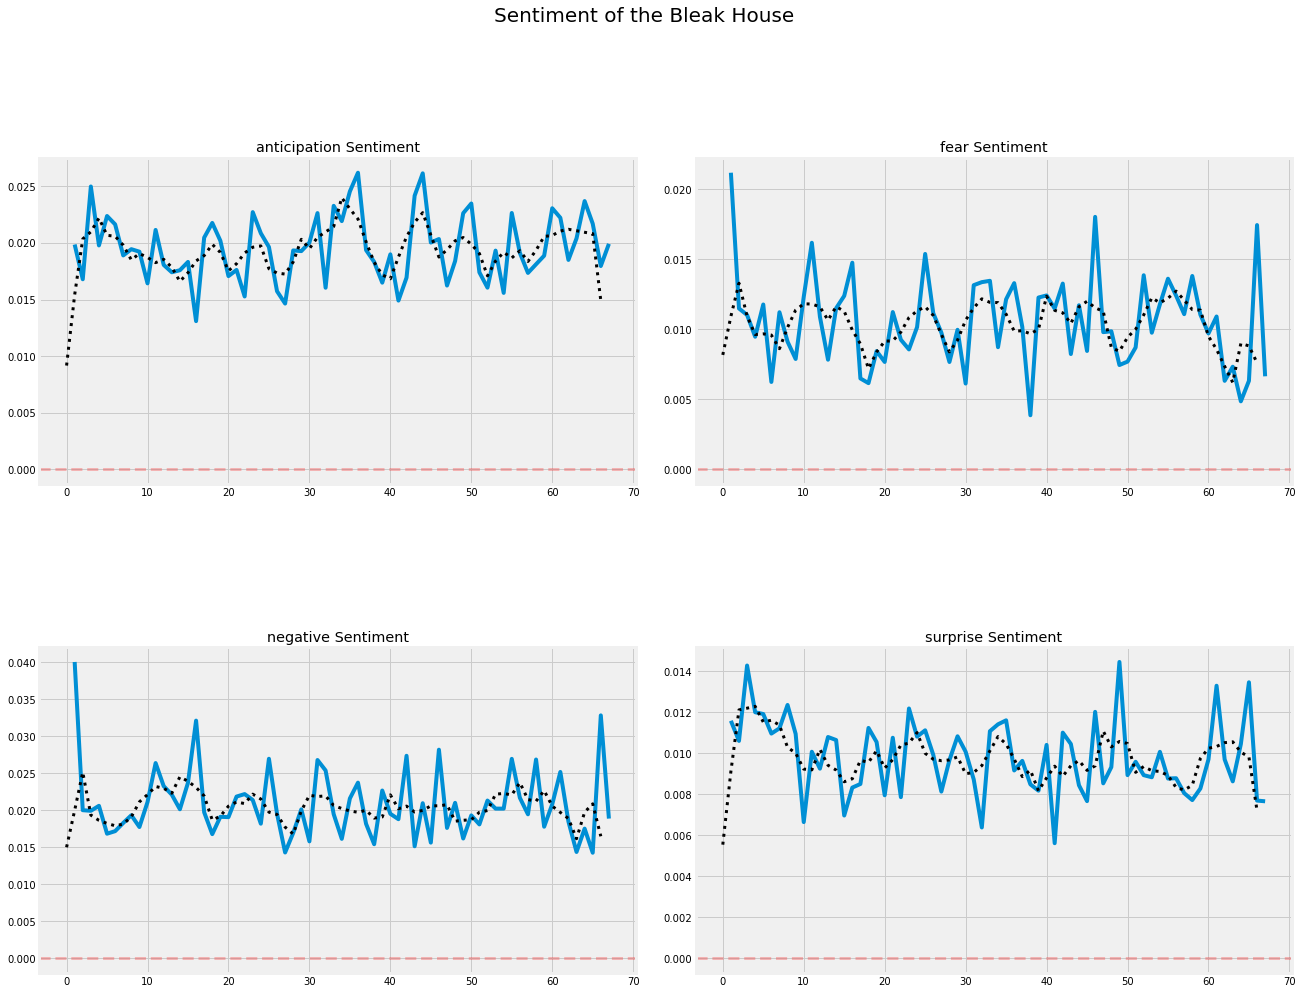

In [192]:
length = 67
x = np.linspace(0, length - 1, num=length)

fig, ax = plt.subplots(2, 2, figsize=(20, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)
fig.suptitle('Sentiment of the Bleak House', fontsize=20, y=1.02)
fig.subplots_adjust(top=0.88)

ax = ax.ravel()

for i in range(10):
    y = hp_df[emotions[i]].to_numpy()
    #print(y)
    ax[i].plot(np.arange(1, 68), y)
    ax[i].set_title('{} Sentiment'.format(emotions[i]))
    ax[i].plot(movingaverage(y, 4), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
    ax[i].axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
    #ax[i].set_xticks([])

fig.tight_layout()
#fig.delaxes(ax[-1])
#fig.delaxes(ax[-2])
plt.savefig('emotion.png')